# __Epidemiological Analysis Visualisations__
         Looking into distribution patterns within a population system: 
      Who, Where and When & linking it to food source attribution What
***

In [352]:
#imported libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

import geopandas as gpd
import plotly.express as px
import fiona
import matplotlib.colors as colors
import matplotlib.patheffects as PathEffects

pd.set_option("display.max_rows", 250)

In [353]:
#imported file with patient metadata and isolate information
#human = pd.read_excel("/directory/file.xlsx", index_col=[0])

df = pd.read_excel("CC1_epi_clean_postcodes.xlsx", index_col=[0])

birthoutcome = pd.read_excel("/home/phe.gov.uk/emily.fotopoulou/Downloads/EF CC1 pregnancy outcomes 16082022.xlsx")
birthoutcome = birthoutcome[["MOLISid", "PregOutcome","InfSurvive"]]
birthoutcome = birthoutcome.rename(columns={"MOLISid": "core_ID"})

human = pd.merge(df, birthoutcome, on="core_ID", how="left")
human = human.loc[human["Specimen Source"]=="Human"]
human.loc[human["InfSurvive"].str.contains("N", na=False), ["PatientDie"]]="PD"
human.rename(columns={"PatientDie":"Clinical outcome",
                     "PAT_PCODE":"Postcode"}, inplace=True)
human

h = pd.read_excel("/home/phe.gov.uk/emily.fotopoulou/Downloads/Github fake data.xlsx", sheet_name = "Sheet1")
h

,Isolates ID,Description,Receipt Date,Sex,Date of birth,Postcode,Clonal Complex,SNP,Cluster Level,Clinical Outcome
0,Isolate_01,IQA,2015-01-31,M,2015-01-31,CH46 6AD,CC1,1.2.3.4.5.6.7,1.2.3.4.5.6,Terminated pregnancy - infant death
1,Isolate_02,repeat,2015-02-02,F,1985-05-01,BN6 9PU,CC1,1.2.3.4.5.6.7,1.2.3.4.5.6,NaN
2,Isolate_03,NaN,2020-04-13,M,1950-10-07,CO10 1RE,CC2,14.15.16.17.18.19.20,14.15.16.17.18.19,NaN
3,Isolate_04,NaN,2015-02-15,F,1935-12-03,CT5 1AQ,CC2,8.9.10.11.12.1.15,8.9.10.11.12.1,Death recorded
4,Isolate_05,IQA,2016-06-12,F,1952-09-03,CT19 4PB,CC8,1.2.3.4.3.7.9,1.2.3.4.3.7,NaN


# 0. Pre - Analysis

## Cleaning data, deduplicating datasets 

* Remove repeated isolates
* Mother-infant pairs treated as a single data entry
* Remove quality isoaltes

For Mother-Infant pairs: Use t5 SNP difference distance to identify isolates with the same digit code profile


In [354]:
# Sub-selecting Clonal complex for analysis - CC1 for this analysis
# human = human.loc[human["Specimen Source"]=="CC1"]

# 1. Who

## Calculate age from patients date of birth and sample collection date

In [355]:
#"Receipt Date" is the sequence collection date
#Alter type of "Receipt Date" and patients "Date of Birth" data into numrical dates with datetime.
human["Date of birth"] = human["Date of birth"].astype(str).str.split(" ",expand=False).str[0]
human["Date of birth"] = pd.to_datetime(human["Date of birth"], format="%Y-%m-%d",
                                       errors='coerce')
human["Receipt Date"] = pd.to_datetime(human["Receipt Date"], format="%Y-%m-%d")

#format diplay of dates into Years and Months only
human["Receipt M-Y"] = pd.to_datetime(human["Receipt Date"], 
                                      format="%Y-%m").dt.to_period("m")
#calculate patient's age
human["Age"] = ((human["Receipt Date"] - human["Date of birth"])/ 
                timedelta(days=365)).round(0)

## Create horizontal pyramid bar plot to visualise patient distribution across age groups

In [356]:
# subselect Age and Sex data from original human dataset
pop = human[["Age", "Sex"]]

#### Create table with sex, age groups and number of cases

In [357]:
#create number of bins for each bracket
bins=[-1,1,6,10,19,29,39,49,58,68,78,88,105]

#label each bin with age bracket
labels = ['0',"1-5",'6-10','11-19','20-29','30-39','40-49','50-59','60-69','70-79', "80-89", "90+"]

#create column named "Age Groups", which contains the labels of the bins generated
a_g = pd.cut(pop["Age"], bins, labels=labels)
pop.insert(2, "Age Groups", a_g)

#group data according to sex
a = pop.groupby("Sex")

#calculate the occurences of each age group bin
a = a["Age Groups"].value_counts().sort_index().to_frame().reset_index()

#rename columns
a.columns= ["Sex", "Age Groups", "Num Isolates"]
a

,Sex,Age Groups,Num Isolates
0,F,0,8
1,F,1-5,2
2,F,6-10,0
3,F,11-19,1
4,F,20-29,13
5,F,30-39,22
6,F,40-49,4
7,F,50-59,3
8,F,60-69,8
9,F,70-79,16


In [358]:
#restructure orientation of df for graph
a = a.pivot(index='Age Groups', columns="Sex", values="Num Isolates")
a

Sex,F,M
Age Groups,,
0,8,4
1-5,2,1
6-10,0,0
11-19,1,1
20-29,13,1
30-39,22,2
40-49,4,6
50-59,3,10
60-69,8,9


#### Ploy horizontal pyramid bar plot

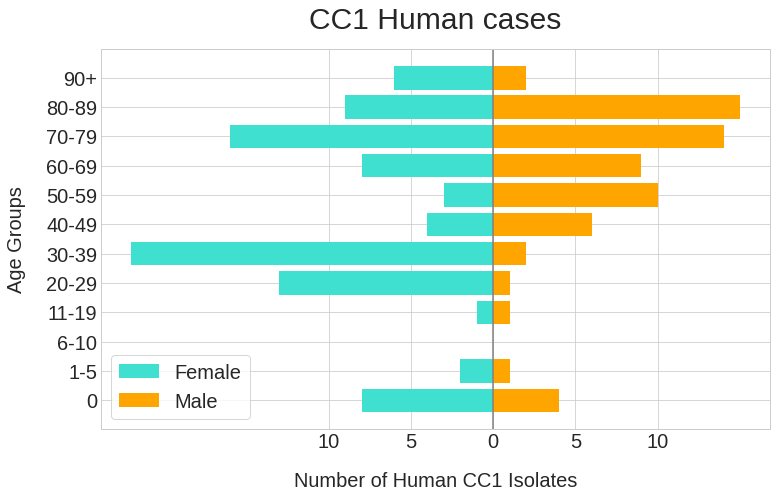

In [359]:
#library for seaborn pallet use 
plt.style.use("seaborn-whitegrid")

#define size of figure
plt.figure(figsize=(12,7))

#matrix with number of cases
no_cases = a.values

#setting y value as the label name of each age bracket
y = a.index

#setting x1 and x2 values as the male and female number of cases per age bracket
x_f= a["F"]*(-1)
x_m= a["M"] 

#matplotlib horizontal bar plot - plotting male and female cases sepatetly
plt.barh(y, x_f, align='center', color='turquoise', label="Female")
plt.barh(y, x_m, align='center', color='orange', label="Male")

#setting x-axis markers and labels
xtickval = [-10, -5, 0, 5, 10]
xticknames = ["10", "5", "0", "5", "10"]
plt.xticks(xtickval, xticknames, fontsize=20)

#setting font for y-axis marker labels
plt.yticks(fontsize=20)

#setting labels for x and y-axis
plt.xlabel("Number of Human CC1 Isolates", fontsize=20, labelpad=20)
plt.ylabel("Age Groups", fontsize=20, labelpad=20)

#setting parameters for legend displayed within the graph
plt.legend(loc="lower left", frameon=True, fontsize=20)

#setting header for figure
plt.title("CC1 Human cases", fontsize=30, pad=20)

#inserting grid on graph
plt.grid(True)

#adjusting the x-axis separating female to male bars
plt.axvline(x=0, linestyle="-",color="gray")

#display figure
plt.show()

## Clinical severity

#### Adding clinical outcome (recorded deaths) to patient distribution pyramid plot

In [360]:
#subselect age, sex and clinical outcome from origincal dataset
ages_death = human[["Age", "Sex","Clinical outcome"]]

same process followed as previous section, however the dataset are now grouped by Clinical outcome and Sex

In [361]:
# #see code above
# s_d_a_iso = ages_death.groupby(["Clinical Outcome", "Sex"])
import warnings 
warnings.filterwarnings('ignore')
bins=[-1,1,6,10,19,29,39,49,58,68,78,88,105]
labels = ['0',"1-5",'6-10','11-19','20-29','30-39','40-49','50-59','60-69','70-79', "80-89", "90+"]

ages_death["Age Groups"] = pd.cut(ages_death["Age"], bins, labels=labels)
ages_death

s_d_a_iso = ages_death.groupby(["Clinical outcome", "Sex"])
s_d_a_iso = s_d_a_iso["Age Groups"].value_counts().sort_index().to_frame().reset_index()
s_d_a_iso.columns= ["Clinical outcome", "Sex", "Age Groups", "Num Isolates"]

In [362]:
#reset orientation of df 
# s_d_a_iso = s_d_a_iso.pivot(index='Age Groups', columns=["Sex", "Clinical Outcome"], 
#                             values="Num Isolates")
s_d_a_iso = s_d_a_iso.pivot(index='Age Groups', columns=["Sex", "Clinical outcome"], 
                            values="Num Isolates")
s_d_a_iso

Sex                F  M  F     M  F  M
Clinical outcome   N  N PD  U  U  Y  Y
Age Groups                            
0                  4  3  0  3  1  0  0
1-5                2  0  0  0  1  0  0
6-10               0  0  0  0  0  0  0
11-19              0  0  0  1  0  0  1
20-29              4  1  3  2  0  0  0
30-39             15  1  4  0  0  0  0
40-49              4  4  0  0  1  0  1
50-59              3  5  0  0  0  0  3
60-69              2  1  0  0  1  6  5
70-79              7  6  0  0  2  6  6
80-89              4  5  0  0  0  5  9
90+                1  1  0  1  0  4  1

#### Pyramid plot with clinical outcome

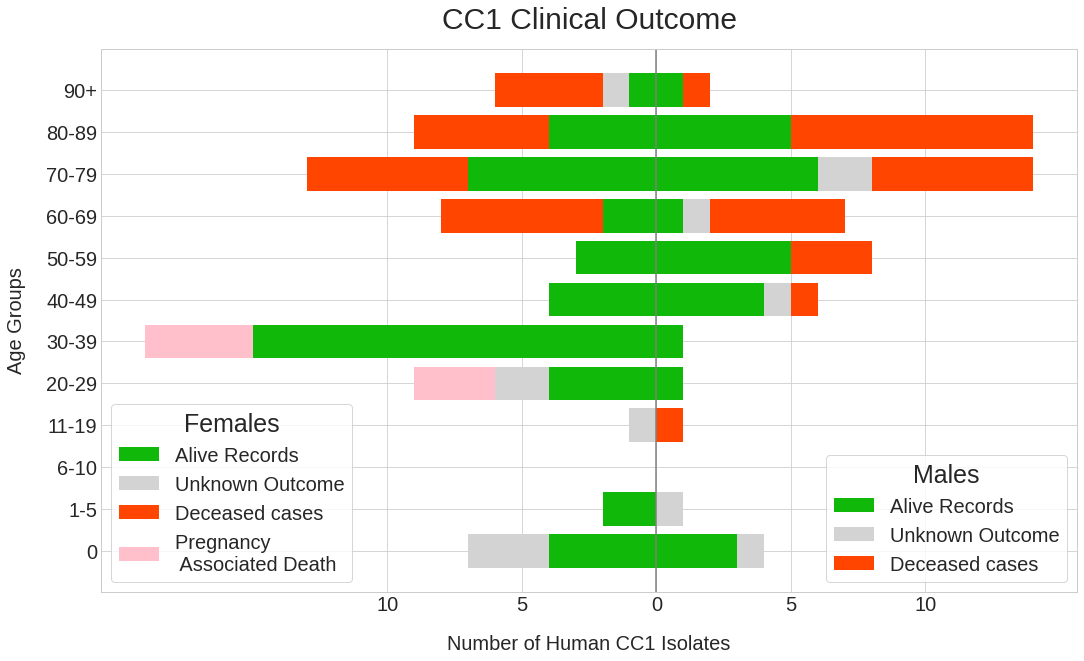

In [363]:
#library for plot pallet with seaborn
plt.style.use("seaborn-whitegrid")

#setting figure size
fig, ax = plt.subplots(figsize=(17.5,10))

#setting parameters for figure and subplots
plt.rcParams["hatch.color"]="floralwhite"
plt.rcParams["hatch.linewidth"]= 4
plt.rcParams["legend.title_fontsize"]=25

#setting x and y variables for plot
y = s_d_a_iso.index

x_f1= s_d_a_iso["F"]["N"]*(-1)
x_f2= s_d_a_iso["F"]["U"]*(-1)
x_f3= s_d_a_iso["F"]["Y"]*(-1)
x_f4= s_d_a_iso["F"]["PD"]*(-1)

x_m1 = s_d_a_iso["M"]["N"]
x_m2 = s_d_a_iso["M"]["U"]
x_m3 = s_d_a_iso["M"]["Y"]

#horizontal bar plot for females
plt.barh(y,x_f1, align='center', color= "#10b80a", label="Alive cases")
plt.barh(y,x_f2, left=x_f1, align='center', color='lightgray', label="Unknown Outcome")
plt.barh(y,x_f3, left=x_f1+x_f2, align='center', color='orangered', label="Deceased cases")
plt.barh(y,x_f4, left=x_f1+x_f2+x_f3, align='center', color='pink', label="Pregnancy Associated Death")

#horizontal bar plot for males
b1 = plt.barh(y,x_m1, align='center', color='#10b80a', label="Alive Records")
b2 = plt.barh(y,x_m2, left=x_m1, align='center', color='lightgray', label="Unknown Outcome")
b3 = plt.barh(y,x_m3, left=x_m1+x_m2, align='center', color='orangered', label="Deceased cases")

#setting x and y-axis as in previous plot
xtickval = [-10, -5, 0, 5, 10]
xticknames = ["10", "5", "0", "5", "10"]
plt.xticks(xtickval, xticknames, fontsize=20)
plt.yticks(fontsize=20)

#axis labels
plt.xlabel("Number of Human CC1 Isolates", fontsize=20, labelpad=20)
plt.ylabel("Age Groups", fontsize=20, labelpad=20)

#setting two legends for each sex
#legend for females
leg = plt.legend(b1, labels=["Alive Records","Unknown Outcome", "Deceased cases", 
                         "Pregnancy \n Associated Death"],
                 loc="lower left", frameon=True, fontsize=20, title="Females")
#adding additional legend
ax.add_artist(leg)
#legend for males
plt.legend(labels=["Alive Records","Unknown Outcome", "Deceased cases"],
           loc="lower right", frameon=True, fontsize=20, title="Males")

#Tittle for figure
plt.title("CC1 Clinical Outcome", fontsize=30, pad=20)

#adjusting the x-axis separating female to male bars
plt.axvline(x=0, linestyle="-",color="gray")

#display plot
plt.show()

# 2. When

## Time series for clinical isolates

detect temporal signal in outbreaks and visualise peaks in cases

creating df with number of cases per set period

In [364]:
#setting data dates into corrent numerical format 
human["Receipt Date"] = pd.to_datetime(human["Receipt Date"], format="%Y-%m-%d")
human["Receipt M-Y"] = pd.to_datetime(human["Receipt Date"], format="%Y-%m").dt.to_period("m")

In [365]:
#count number of cases per month
time_hum = human["Receipt M-Y"].loc[human["Specimen Source"]=="Human"].value_counts().sort_index().to_frame().reset_index()
#reset column headers
time_hum.columns=["Receipt M-Y", "No Isolates"]
time_hum.head()

,Receipt M-Y,No Isolates
0,2015-01,2
1,2015-03,3
2,2015-05,5
3,2015-06,5
4,2015-07,4


#### Time series plot

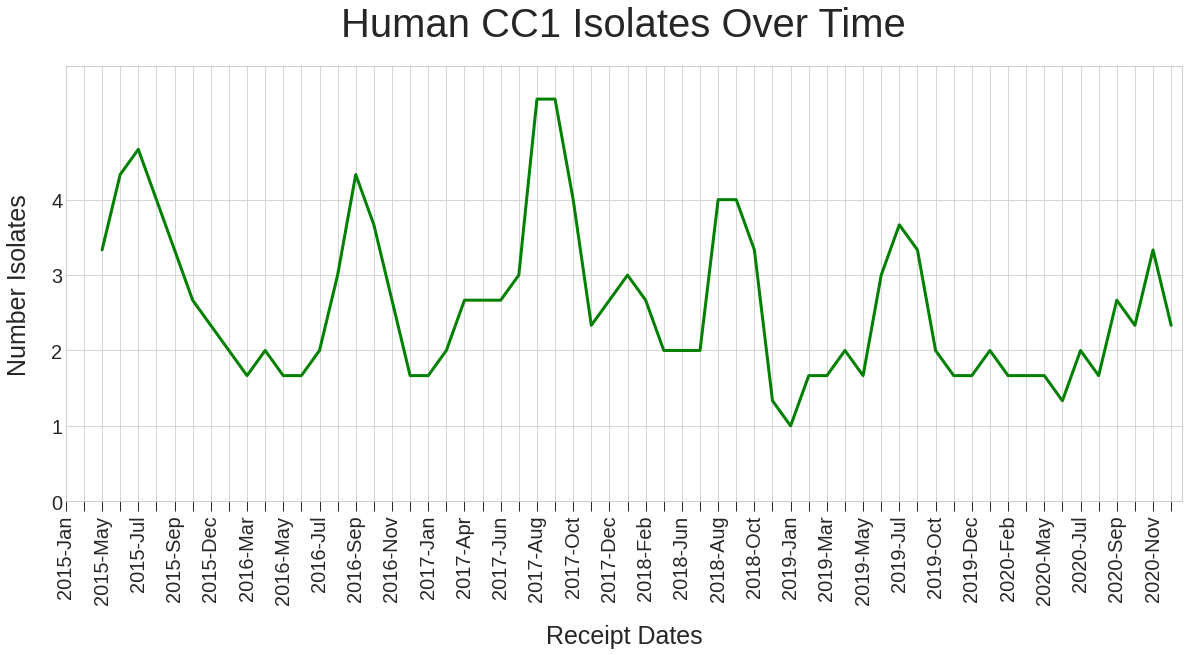

In [366]:
#import seaborn library for plot visualisation
import seaborn as sns

#set figure parameters  
plt.style.use("seaborn-whitegrid")
plt.rcParams["xtick.major.size"]= 10
plt.rcParams["xtick.major.width"]= 1
fig = plt.figure(figsize=(20,8))
#adjust white space in axis
plt.margins(0.01,0.1)

#setting dates in the right numberical format for x-axis
x_dates = time_hum["Receipt M-Y"].dt.strftime("%Y-%b")
x_range = np.arange(len(x_dates))

#plot
plot = sns.lineplot(x_range, time_hum["No Isolates"].rolling(3).mean(), color="green", linewidth=3)
#axis labels
plt.xlabel("Receipt Dates", fontsize=25, labelpad=20)
plt.ylabel("Number Isolates", fontsize=25, labelpad=20)

#set x and y-axis markers and labels
plt.xticks(x_range, x_dates, fontsize=20, rotation=90)
plt.yticks(np.arange(0,5), fontsize=20)

#skip every other tick marker point on axis
for ind, label in enumerate(plot.get_xticklabels()):
    if ind % 2 == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)

#set Tittle for figure
plt.title("Human CC1 Isolates Over Time", fontsize=40, pad=30)

#display figure
plt.show()

# 3. Where

## Display clinical cases on map

#### detect temporal signal on cases and see geographic distribution
to plot a map with geopandas a shape file (.shp) is required. 
for analysis all files containing geographic information where downloaded from the ONS site


https://geoportal.statistics.gov.uk/search?q=BDY_ADM&sort=Date%20Created%7Ccreated%7Cdesc

In [367]:
# #import shape file and files with postcode information
# shape = gpd.read_file("/directory/shape_file.shp")
# national_postcodes = pd.read_csv("postcodes.csv")
# national_postcodes = national_postcodes[["Postcode 3", "Longitude", "Latitude"]]
# national_postcodes.rename(columns = {'Postcode 3':'Postcode'}, inplace = True)


shape = gpd.read_file("/home/phe.gov.uk/emily.fotopoulou/Downloads/RGN_DEC_2021_EN_BFC.shp")

national_postcodes = pd.read_csv("/home/phe.gov.uk/emily.fotopoulou/Downloads/National_Statistics_Postcode_Lookup_UK_Coordinates.csv")
national_postcodes = national_postcodes[["Postcode 3", "Longitude", "Latitude"]]
national_postcodes.rename(columns = {'Postcode 3':'Postcode'}, inplace = True)

In [368]:
# #edditing human dataframe data to include coordinates
# #add postcode information on human dataset
# human_lon_lat = pd.merge(human, national_postcodes, on="Postcode", how="left")

#convert dataset to correct format with geopandas for map plot
hum_geo = gpd.GeoDataFrame(human_lon_lat, 
                           geometry = gpd.points_from_xy(human_lon_lat["Longitude"], 
                                                         human_lon_lat["Latitude"]))

#remove isolates from Wales, Scotland and N.Ireland
hum_geo = hum_geo.drop(hum_geo.loc[hum_geo["Country"].str.contains("Scotland|Wales|Northern Ireland", 
                                                              case=False, na=False)].index)


In [369]:
# #add UK population size so generate heatmap of population density from ONS
# #RGN21CD column header is set within the ONS population density dataset and lists the different UK geographical regions 
# popsize = pd.read_excel("/directory/uk_population.xlsx", 
popsize = pd.read_excel("/home/phe.gov.uk/emily.fotopoulou/Downloads/ukpopestimatesmid2020on2021geography.xls", 
                        sheet_name = "MYE2 - Persons", skiprows=range(1,7), header=1)
popsize.rename(columns = {'Code':'RGN21CD'}, inplace = True)
popsize = popsize[["RGN21CD", "All ages"]]

#add population information to shape file
shape = pd.merge(shape, popsize, on="RGN21CD", how="left")

#rename regions column
shape = shape.rename(columns={"RGN21NM":"Region"})

In [370]:
#adding regions to human data
# areas = pd.read_excel("/directory/region_areas.xlsx")
areas = pd.read_excel("/home/phe.gov.uk/emily.fotopoulou/Downloads/Post code areas UK.xlsx")
areas = areas[['Postcode area', "Region"]]

hum_geo["Postcode area"] = hum_geo["Postcode"].str.extract(r'(^[A-Z]{1,2})')[0]

hum_geo = pd.merge(hum_geo, areas, on="Postcode area")

In [371]:
#calculate data and values for plots
counts = hum_geo["Region"].value_counts().to_frame().reset_index()
counts.columns = ["Region", "Cases"]

#setting centroids and coordinates
#calculate centroids for scatter plot
shape['centroid'] = shape["geometry"].centroid
shape["x"] = shape["centroid"].x
shape["y"] = shape["centroid"].y
shape["Specimen Source"]="Human"

#edit shape file regions to the same names
shape.loc[shape["Region"]=="East of England", "Region"]="East"
shape.loc[shape["Region"]=="Yorkshire and The Humber", "Region"]="Yorkshire Humber"

#add counts for cases on shape file
shape = pd.merge(shape, counts, how="left", on="Region")

In [372]:
#edit projections for geopandas to register geographic coordinates for longitude and latitude
#requires fiona library
shape = shape.to_crs(epsg=4326)

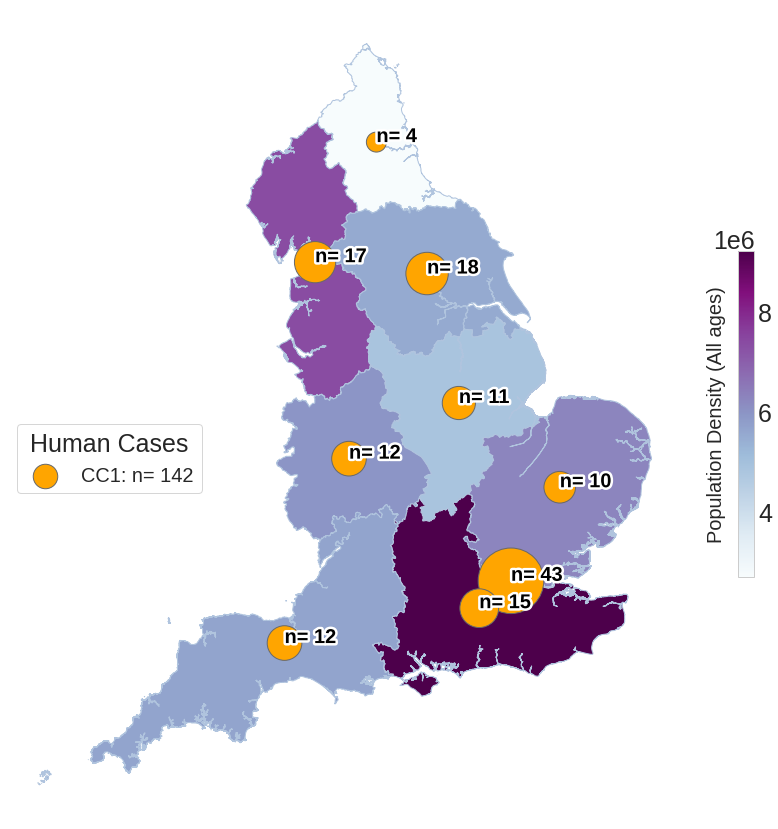

In [373]:
import warnings 
warnings.filterwarnings('ignore')
from matplotlib.colors import LinearSegmentedColormap

# plotting parameters
fig, ax = plt.subplots(figsize=(20, 15))
plt.rcParams["font.size"] = 25

#first plot of the UK map representing the population density as a heat map
shape.plot(ax=ax, column="All ages", edgecolor="lightsteelblue", cmap="BuPu")

# Normalize population density for color mapping
norm = plt.Normalize(shape['All ages'].min(), shape['All ages'].max())

# Add a colorbar for heat map of population density
sm = plt.cm.ScalarMappable(cmap="BuPu", norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', shrink=0.4)
cbar.set_label('Population Density (All ages)', labelpad=-65, fontsize=20)


#scatter plot
shape.centroid.plot(ax=ax, color="orange", edgecolors="dimgray",
               markersize=shape["Cases"]* 100, 
                    label='CC1: n= {}'.format(shape["Cases"].sum()))
#scatter plot legend
legend = ax.legend(title="Human Cases", scatterpoints=1, loc="upper left", fontsize=20,
                    bbox_to_anchor=(0, 0.5), 
                    frameon=True)
#adjusting size of bubble in legend
for handle in legend.legendHandles:
    handle.set_sizes([600])


#set labels for markers on map
for i, text in enumerate(shape["Cases"].values):
    t = plt.annotate('n= {}'.format(text), (shape.centroid.x[i], shape.centroid.y[i]), 
                fontsize=20, color="black", weight="black")
    t.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])

#remove axis of plot
plt.axis("off")
#display plot
plt.show()

# 4. What

## Visualising food groups most commonly sampled from food samples 

## Pre - Analysis

In [374]:
# #import food data
# env_food = pd.read_excel("/directory/food_samples.xlsx", index_col=[0])
# #remove duplocated isolates
# env_food = env_food.drop(env_food.loc[env_food["Duplicates?"]=="D"].index)

food = df.loc[df["Specimen Source"]=="Food"]

f= pd.read_excel("/home/phe.gov.uk/emily.fotopoulou/Downloads/CC1_2_8_9_food_categoriesV3fj.xlsx")
f = f[["name","Food_Category_V2","Duplicates"]]
food = pd.merge(food, f, on="name")

food = food.drop(food.loc[food["Food_Category_V2"].str.contains("no info", case=False, na=False)].index)
food = food.drop(food.loc[food["Food_Category_V2"].str.contains("swab", case=False, na=False)].index)
food.loc[food["Food_Category_V2"]=="cook-chill", "Food_Category_V2"]="Chill and Cook Meals"
food.loc[food["Food_Category_V2"]=="RTE (with fish)", "Food_Category_V2"]="Fish"
food.loc[food["Food_Category_V2"]=="Other RTE (incl. sandwiches, mixed salads)", "Food_Category_V2"]="Other RTE \n (incl. sandwiches, mixed salads)"
food.loc[food["Food_Category_V2"]=="Dairy (incl. pasteurised/raw)", "Food_Category_V2"]="Dairy \n (incl. pasteurised/raw)"
food.loc[food["Food_Category_V2"]=="Veg & Fruit (fresh&frozen)", "Food_Category_V2"]="Veg & Fruit \n (fresh&frozen)"
food["Food_Category_V2"] = food["Food_Category_V2"].replace("deli/charcuterie foods (incl. cooked and cured meats)","Deli/Charcuterie foods \n (incl. cooked and cured meats)")

f2 = pd.read_excel("/home/phe.gov.uk/emily.fotopoulou/Downloads/Github fake data.xlsx", sheet_name = "Sheet2")
f2

,Isolates ID,Description,Duplicates?,Receipt Date,Postcode,Clonal Complex,SNP,Cluster Level
0,Isolate_06,Ham,Y,2020-04-04,CH50 6AD,CC8,1.1.2.2.3.10.7,1.1.2.2.3.10
1,Isolate_07,Raw Sausages,N,2017-08-20,BJ60 9PE,CC9,2.2.2.2.5.8.7,2.2.2.2.5.8
2,Isolate_08,Packaged salad,N,2015-09-29,CX80 1RE,CC9,2.2.2.2.5.6.8,2.2.2.2.5.6
3,Isolate_09,Sandwich,N,2020-06-03,CZ5 1AX,CC9,2.2.2.2.5.6.8,2.2.2.2.5.6
4,Isolate_10,Frozen Sweetcorn,N,2016-10-05,CL30 4PB,CC2,14.15.16.17.18.19.20,14.15.16.17.18.19


In [375]:
# Sub-selecting Clonal complex for analysis - CC1 for this analysis
# food = food.loc[human["Specimen Source"]=="CC1"]

#### Group foods into food categories

In [376]:
# food = env_food.loc[env_food["Specimen Source"]=="Food"]

# food.loc[~(food["Food Category"].str.contains("^[A-Z]", case=False, na=False)) & 
#          (food["Description"].str.contains("Salmon|cod|trout|...'fresh fish'", 
#                                        case=False)), "Food Category"]="Fish"

# food.loc[~(food["Food Category"].str.contains("^[A-Z]", case=False, na=False)) & 
#          (food["Description"].str.contains("Pizza|cooked rice|...'ready-made, package foods'", 
#                                        case=False)), "Food Category"]="Chill and Cook Meals"

# food.loc[~(food["Food Category"].str.contains("^[A-Z]", case=False, na=False)) & 
#          (food["Description"].str.contains("chorizo|salami|sliced|...'cured and processed meat products'", 
#                                        case=False)), "Food Category"]="Deli/Charcuterie foods \n (incl. cooked and cured meats)"

# food.loc[~(food["Food Category"].str.contains("^[A-Z]", case=False, na=False)) & 
#          (food["Description"].str.contains("salad|sandw|...'RTE produce'", 
#                                        case=False)), "Food Category"]="Other RTE \n (incl. sandwiches, mixed salads)"

# food.loc[~(food["Food Category"].str.contains("^[A-Z]", case=False, na=False)) & 
#          (food["Description"].str.contains("ice cream|milk|cheese|...'dairy_produce'", 
#                                        case=False)), "Food Category"]="Dairy \n (incl. pasteurised/raw)"

# food.loc[~(food["Food Category"].str.contains("^[A-Z]", case=False, na=False)) & 
#          (food["Description"].str.contains("lettuce|sweetcorn|melon...'frozen and fresh fruit and veg'", 
#                                        case=False)), "Food Category"]="Veg & Fruit \n (fresh&frozen)"

#### pie chart plot of all food groups

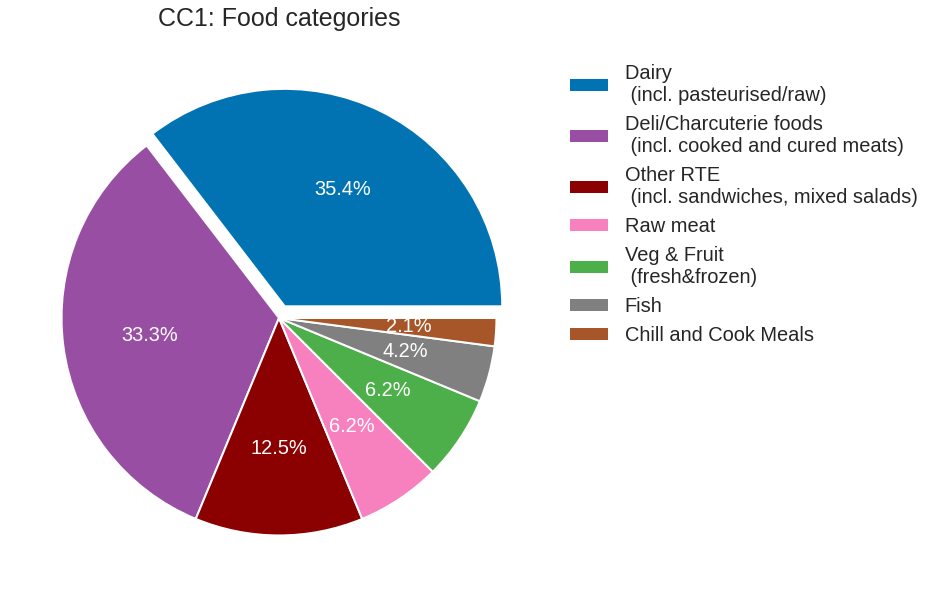

In [377]:
#generate table with food categories and colours 
c = {"Dairy \n (incl. pasteurised/raw)":"#0173b2", 
     "Fish":"gray", 
     "Veg & Fruit \n (fresh&frozen)":"#4daf4a", 
     "Other RTE \n (incl. sandwiches, mixed salads)":"darkred", 
     "Chill and Cook Meals":"#a65628", 
     "Deli/Charcuterie foods \n (incl. cooked and cured meats)":"#984ea3", 
     "Raw meat":"#f781bf"}

t = food["Food_Category_V2"].value_counts().to_frame()

t["colours"]=t.index.to_series().map(c)
t = t.T

#set figure size
plt.figure(figsize=(10,10))

#set variables for plot
v = t.loc["Food_Category_V2"].values

# #pie chart plot
plots, text, precent = plt.pie(v, colors= t.loc["colours"].values, 
                              autopct="%1.1f%%", textprops={"fontsize":20}, startangle=0,
       explode=[0.06,0,0,0,0,0,0],
       wedgeprops={"linewidth":2.0, "edgecolor":"white"})

#set precentage parameters
plt.setp(precent,color="w", fontweight="medium")

#set figure legend
plt.legend(labels=t.columns, loc="upper left", fontsize=20, bbox_to_anchor=(1,1))

#set Tittle for figure
plt.title("CC1: Food categories", fontdict={"fontsize":25}, pad=20)

#display figure
plt.show()

Deduplicate dataset:
keep a sigle entry for isolates with:
* the same t5 SNP dirrerence
* the same sequence collection date
* collected at the same location

Reduces bias of sampling and normalises population

In [378]:
#food_dedup = food.drop_duplicates(subset=["Description","Receipt M-Y", "SNP Level 5"],keep="first")

#### repeat same steps to generate pie chart plot for deduplicated dataset

this analysis allows for the investigation and comparison of both raw sample collection and the representative population structure

In [379]:
food = food.rename(columns={"Surname":"Description"})
food = food.drop(food.loc[food["Duplicates"].str.contains("d|y", case=False, na=False)].index)

food_dedup = food.drop_duplicates(subset=["Description","Receipt M-Y", "SNP Level 5"],keep="first")
food_dedup["Food_Category_V2"].value_counts()
food_dedup["name"]

food_dedup = food_dedup.drop(food_dedup.loc[food_dedup["name"].str.contains("H154940498")].index)

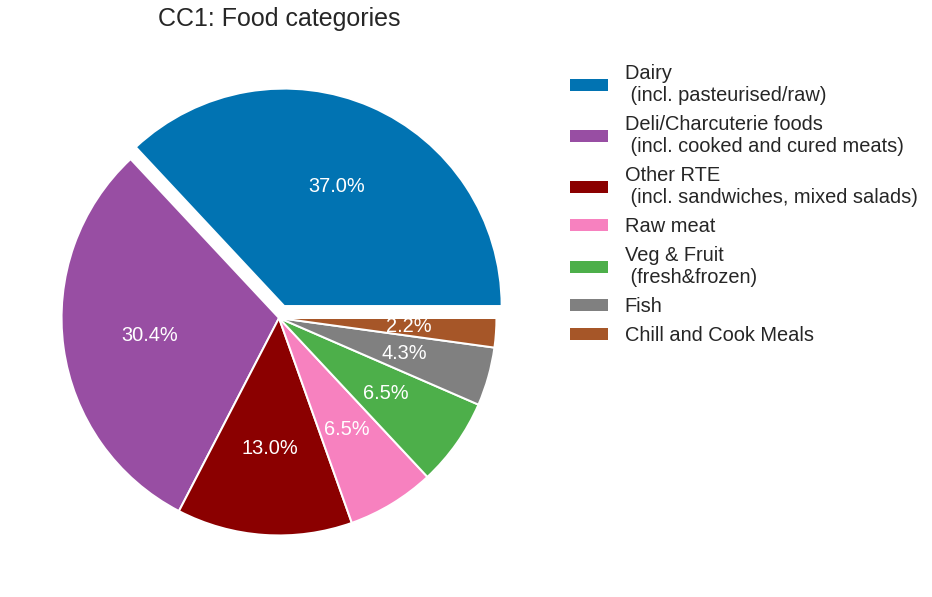

In [380]:
#see code above
#Normalised

t = food_dedup["Food_Category_V2"].value_counts().to_frame()

t["colours"]=t.index.to_series().map(c)
t = t.T

v = t.loc["Food_Category_V2"].values


# ######################################
plt.figure(figsize=(10,10))
# # #sns.set_palette("colorblind")


plots, text, precent = plt.pie(v, colors= t.loc["colours"].values, 
                              autopct="%1.1f%%", textprops={"fontsize":20}, startangle=0,
       explode=[0.06,0,0,0,0,0,0],
       wedgeprops={"linewidth":2.0, "edgecolor":"white"})

plt.setp(precent,color="white", fontweight="medium")

plt.legend(labels=t.columns, loc="upper left", fontsize=20, bbox_to_anchor=(1,1))

plt.title("CC1: Food categories", fontdict={"fontsize":25}, pad=20)
plt.show()